# Dynamic programming, with precalulation

From the book:

We first pre-calculate the table with 
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$

Then we approximate the exponent by, which is to be maximised:
$$
- \sum_{k=1}^{K} \sum_{n_k - 1}^{n_k - p_k} (s(n_k+p_k)-s(n))^2
$$

which is approximated by
$$
- 2 \sum_{n=1}^{40000} s(n)^2 + 2 \sum_{k=1}^{K}(C(n_k,p_k) - C(n_{k-1},p_k))
$$

Our objective is to $\textbf{minimise}$ the summation
$$
\sum_{k=1}^{K}(C(n_{k-1},p_k) - C(n_k,p_k))
$$

Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Parameters Definition

In [2]:
# range of possible periods
period_lower_range = 5
period_upper_range = 40
P = np.arange(period_lower_range, period_upper_range)  # list of periods to loop

# downsample rate
# what is the fraction of the bit_rate of the audio (REPHRASE)
downsample_rate = 5

# skip rate
# how much to skip in the calculation of the nll (REPHRASE)
skip_rate = 40

# penalty rate
# how much to increase the nll for every new note
penalty = 0.54

Holding variables definition

Loading and visualising soundfile

sampling rate: 44100


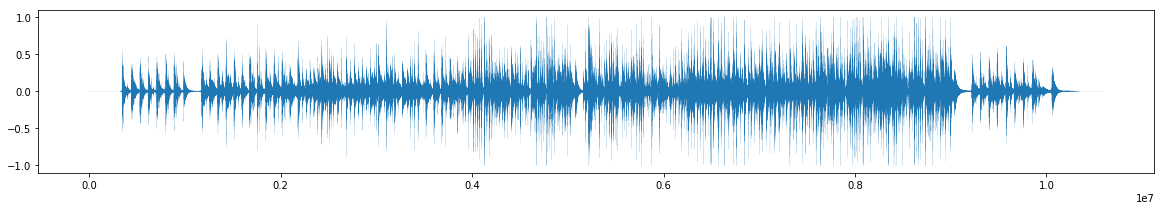

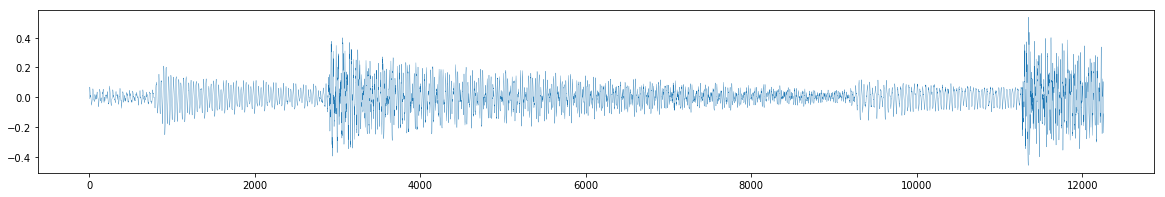

In [3]:
import os
import soundfile as sf
# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
file_name = os.path.join(fileDir, '../sounds/uku_canon.wav')
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)

print("sampling rate: {}".format(sample_rate))

plt.figure(figsize=(20,3))
plt.plot(ref[:,0],lw=0.1)  # audio imported may be steoro, hence ref[:0]
plt.show()

signal = ref[int(61.51*44100):int(62.9*44100):downsample_rate,0]

import sounddevice as sd
sd.play(signal, 44100/downsample_rate)

# print(signal)
plt.figure(figsize=(20,3))
plt.plot(signal,lw=0.3)
plt.show()

In [4]:
nll2 = np.zeros(len(signal)-period_upper_range)  # initialise list of nll2nents
nll2_t_ = np.zeros(len(signal)-period_upper_range)  # initialise list of nll2nents
nll2_p = np.zeros(len(signal)-period_upper_range)  # initialise list of nll2nents

## Precalculation
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$
Array index is not the actual period length, however:

`cee[n][p-cee_period_plot_start]` $ = C(n,p)$ 

Takes $p$ cummulative summation calcuations of length of the size of the snippet.

In [5]:
cee_time_plot_start = 0 # try 0
cee_time_plot_end = len(signal)-period_upper_range # try 2000
cee_time_plot_range = cee_time_plot_end - cee_time_plot_start
cee_period_plot_start = period_lower_range # try 0
cee_period_plot_end = period_upper_range # try 100
cee_period_plot_range = cee_period_plot_end - cee_period_plot_start

X = np.arange(cee_time_plot_start, cee_time_plot_end, 1)
Y = np.arange(cee_period_plot_start, cee_period_plot_end, 1)

cee = np.zeros((cee_time_plot_range, cee_period_plot_range))

for p in range(cee_period_plot_start, cee_period_plot_end):
    p_ = p - cee_period_plot_start  # array index is not actual period length
    cee[:,p_] = np.cumsum(np.multiply(signal[:cee_time_plot_end],
                                    signal[p:cee_time_plot_end+p]))
    
# print(cee)

Minimise the nll (negative log-likelihood), for a given $t$ and $t'$ over $p$.  <br/>
Function returns the value of the minimum nll, and its corresponding $p$. <br/>
Takes $p$ addition calculations

In [6]:
def lel(t_,t,P):
    logexp_list_vary_p = []
    p_list = []
    
    for p in P:
        p = p-5
        if t_ + p < t:
            logexp_list_vary_p.append(cee[t,p] - cee[t_,p])
            p_list.append(p+3)
    arg_min = np.argmin(logexp_list_vary_p)
    return logexp_list_vary_p[arg_min] + penalty, p_list[arg_min]

In [7]:
# # minimise over p, not using cee
# def lel(t_,t,P):
# #     print("\n{}~{}:".format(t_, t), end='')
    
#     logexp_list_vary_p = []
#     p_list = []
    
#     for p in P:
#         if t_ + p < t:
#             to_append = np.sum([(signal[k+p] - signal[k])**2 for k in range(t_,t-p)])
# #             print(" p{}-{:.3f}  ".format(p,to_append), end='')
#             logexp_list_vary_p.append(to_append)
#             p_list.append(p)
#     arg_min = np.argmin(logexp_list_vary_p)
#     return logexp_list_vary_p[arg_min] + 0.2, p_list[arg_min]

Minimise the nll (negative log-likelihood), for a given $t$ over $t'$ with its corresponding $p$.  <br/>
Function returns the value of the minimum nll, and its corresponding $t'$ and $p$. <br/>
Calls the nll function ($p$ calcuations) $t$ times - total of $pt$ times.

In [8]:
def lol(t):
    print("nll[{}]".format(i), end='')
    
    logexp_list_vary_t_ = []
    t__list = []
    p_min_list = []
    
    for t_ in range(t-3):
        value, p_min = lel(t_,t,P)
        logexp_list_vary_t_.append(value)
        t__list.append(t_)
        p_min_list.append(p_min)
        
    nll_sum = np.add(logexp_list_vary_t_, nll2[:len(logexp_list_vary_t_)])
    
    arg_min = np.argmin(nll_sum)
    
    nll2[t] = nll_sum[arg_min]
    
    nll2_p[t] = p_min_list[arg_min]
    nll2_t_[t] = t__list[arg_min]
    print(" \t min = {:5f} at t'={} and p={} \n".format(nll2[i], nll2_t_[i], nll2_p[i]), end='')

Build the nll from a low t (starting with zeroes). <br/>
Calls the lol function $l$ times, calls the nll function a total of $\frac{1}{2} l^2 p$

In [9]:
for i in np.arange(skip_rate,len(nll2),skip_rate):
# for i in range(4,10):
    lol(i)

nll[40] 	 min = 0.505973 at t'=0.0 and p=17.0 
nll[80] 	 min = 0.497587 at t'=3.0 and p=16.0 
nll[120] 	 min = 0.471113 at t'=4.0 and p=15.0 
nll[160] 	 min = 0.443871 at t'=3.0 and p=16.0 
nll[200] 	 min = 0.433280 at t'=3.0 and p=16.0 
nll[240] 	 min = 0.410011 at t'=4.0 and p=15.0 
nll[280] 	 min = 0.373918 at t'=3.0 and p=16.0 
nll[320] 	 min = 0.361041 at t'=3.0 and p=16.0 
nll[360] 	 min = 0.343177 at t'=3.0 and p=16.0 
nll[400] 	 min = 0.300255 at t'=3.0 and p=16.0 
nll[440] 	 min = 0.297030 at t'=3.0 and p=16.0 
nll[480] 	 min = 0.278548 at t'=3.0 and p=16.0 
nll[520] 	 min = 0.259183 at t'=3.0 and p=16.0 
nll[560] 	 min = 0.249937 at t'=3.0 and p=16.0 
nll[600] 	 min = 0.231365 at t'=3.0 and p=16.0 
nll[640] 	 min = 0.206401 at t'=3.0 and p=16.0 
nll[680] 	 min = 0.198485 at t'=3.0 and p=16.0 
nll[720] 	 min = 0.177656 at t'=0.0 and p=17.0 
nll[760] 	 min = 0.146707 at t'=0.0 and p=17.0 
nll[800] 	 min = 0.087388 at t'=0.0 and p=17.0 
nll[840] 	 min = -0.152994 at t'=3.0 and p

nll[6360] 	 min = -42.324709 at t'=2920.0 and p=10.0 
nll[6400] 	 min = -42.420034 at t'=2920.0 and p=10.0 
nll[6440] 	 min = -42.539527 at t'=2920.0 and p=10.0 
nll[6480] 	 min = -42.621228 at t'=2920.0 and p=10.0 
nll[6520] 	 min = -42.741218 at t'=2920.0 and p=10.0 
nll[6560] 	 min = -42.755678 at t'=2920.0 and p=10.0 
nll[6600] 	 min = -42.977009 at t'=2920.0 and p=10.0 
nll[6640] 	 min = -43.006737 at t'=2920.0 and p=10.0 
nll[6680] 	 min = -43.094223 at t'=2920.0 and p=10.0 
nll[6720] 	 min = -43.216258 at t'=2920.0 and p=10.0 
nll[6760] 	 min = -43.238216 at t'=2920.0 and p=10.0 
nll[6800] 	 min = -43.401717 at t'=2920.0 and p=10.0 
nll[6840] 	 min = -43.443648 at t'=2920.0 and p=10.0 
nll[6880] 	 min = -43.589254 at t'=2920.0 and p=10.0 
nll[6920] 	 min = -43.708514 at t'=2920.0 and p=10.0 
nll[6960] 	 min = -43.775190 at t'=2920.0 and p=10.0 
nll[7000] 	 min = -43.853216 at t'=2920.0 and p=10.0 
nll[7040] 	 min = -43.866396 at t'=2920.0 and p=10.0 
nll[7080] 	 min = -43.940726

## traceback algorithm
Building the score from the back, by finding the route that gave the minimum nll.

In [10]:
t_list = []
p_list = []

k = 12000  # some error need to debug
# k = int(len(nll2_t_ - len(nll2_t_)%skip_rate) - skip_rate)
# print(k)
# print(nll2_t_[12000])
while True:
    t_list.append(k)
    p_list.append(nll2_p[k])
    k = int(nll2_t_[k])  # go to the previous t_
    # when we reach the start we stop the loop
    if k == 0:
        t_list.append(k)
        break

t_list = t_list[::-1] # to reverse the list
p_list = p_list[::-1]
f_list = np.ceil(np.reciprocal(p_list[1:])*44100/downsample_rate)
print(t_list)
print(p_list)
print(f_list)  # list of associated frequencies

[0, 6, 2920, 9240, 11280, 11320, 12000]
[0.0, 13.0, 10.0, 14.0, 37.0, 9.0]
[ 679.  882.  630.  239.  980.]


## plotting the graph
Graph contains the trend of minimum nll at every time t, the trend of associated period, a fixed fraction (so to align with the graph) difference between the current time and the time 

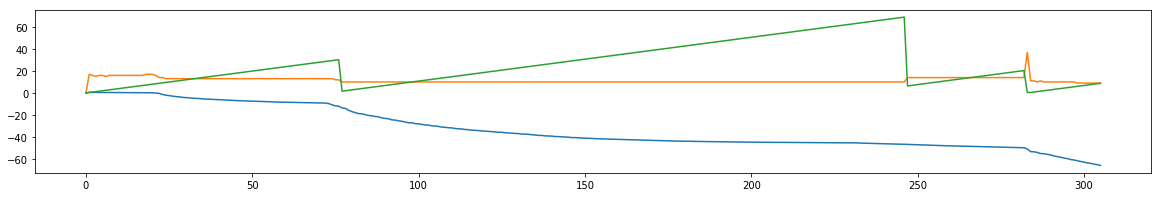

In [11]:
plt.figure(figsize=(20,3))
plt.plot(nll2[::skip_rate])
plt.plot(nll2_p[::skip_rate])
plt.plot(0.01*(np.arange(0,len(signal)-period_upper_range,skip_rate)-nll2_t_[::skip_rate]))
plt.show()

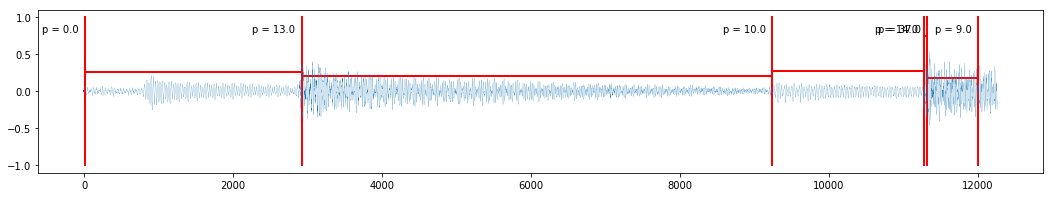

In [12]:
plt.figure(figsize=(18,3))
for k in range(len(p_list)):
    plt.plot([t_list[k+1], t_list[k+1]], [-1, 1], color='r', linestyle='-', linewidth=2)
    plt.plot([t_list[k], t_list[k+1]], [0.02*p_list[k], 0.02*p_list[k]], color='r', linestyle='-', linewidth=2)
    plt.text(t_list[k+1], 0.8, "p = {}  ".format(p_list[k]), horizontalalignment='right')
plt.plot(signal, lw=0.2)
plt.show()

In [13]:
# do the ground truth
# create page, resource 